In [1]:
import sys
sys.path.append("/home/nschulte/.local/lib/python3.11/site-packages")
#!pip install triggercalib==1.4.0

In [2]:
import sys
import numpy as np
import uproot
import awkward as ak
import polars as pl
import pandas as pd
import ROOT as R
import matplotlib.pyplot as plt
import mplhep as hep
import os 

hep.style.use("LHCb2")

Welcome to JupyROOT 6.30/04


In [3]:
import triggercalib
print(sys.path)
from triggercalib import HltEff

['/home/nschulte/hlt2topo_sp/commissioning/efficiencies', '/opt/miniconda/envs/root_forge/lib/python311.zip', '/opt/miniconda/envs/root_forge/lib/python3.11', '/opt/miniconda/envs/root_forge/lib/python3.11/lib-dynload', '', '/home/nschulte/.local/lib/python3.11/site-packages', '/opt/miniconda/envs/root_forge/lib/python3.11/site-packages', '/home/nschulte/.local/lib/python3.11/site-packages']


In [4]:
def tgraph_to_np(th1, x_scale=1):
    histogram = uproot.from_pyroot(th1)
    print("Values from histogram:", histogram.values())
    xvals, yvals = histogram.values()
    xlow_errs, ylow_errs = histogram.errors("low")
    xhigh_errs, yhigh_errs = histogram.errors("high")

    return xvals, yvals, (xlow_errs, xhigh_errs), (ylow_errs, yhigh_errs)

In [5]:
def plot_TOS_efficiency(hlt_eff_object, dataframe, variable, efficiency_name, outputpath, line):
    # Extract efficiency data
    midpoints, values, xerrors, yerrors = tgraph_to_np(hlt_eff_object["efficiencies"][f"tos_efficiency_{variable}"])
    
    # Compute bin edges from midpoints
    bin_edges = [midpoints[0] - (midpoints[1] - midpoints[0]) / 2]  # Left edge of the first bin
    for i in range(len(midpoints) - 1):
        bin_edges.append(midpoints[i] + (midpoints[i + 1] - midpoints[i]) / 2)
    bin_edges.append(midpoints[-1] + (midpoints[-1] - midpoints[-2]) / 2)  # Right edge of the last bin
    
    # Calculate x-axis range
    xmin, xmax = bin_edges[0], bin_edges[-1]

    # Plot the efficiency
    plt.figure(figsize=(12, 10))
    plt.plot((xmin, xmax), (1, 1), color='k', ls='dashed', lw=2)
    plt.errorbar(
        x=midpoints, y=values, xerr=[xerrors[0], xerrors[1]], yerr=yerrors,
        color='r', elinewidth=2, ls="none", marker='.', markersize=8, label=f"Efficiency {line}"
    )

    # Plot variable distribution
    hist_values, _ = np.histogram(dataframe[variable], bins=bin_edges)
    
    # Normalize histogram to match efficiency range
    hist_max = hist_values.max()
    efficiency_max = values.max()
    scaling_factor = efficiency_max / hist_max
    scaled_hist_values = hist_values * scaling_factor  # Scale histogram to efficiency range
    
    # Plot histogram as a filled distribution
    plt.bar(
        bin_edges[:-1], scaled_hist_values, width=np.diff(bin_edges), align='edge',
        color='grey', alpha=0.5, edgecolor='none'
    )

    # Set axis limits and labels
    plt.xlim(xmin, xmax)
    plt.ylim(0, max(efficiency_max, scaled_hist_values.max()) * 1.1)  # Adjust y-axis range
    plt.xlabel(r"Transverse momentum, $p_T\left(B^+\right)$ / $\mathrm{MeV}c^{-1}$")
    plt.ylabel(r"TOS efficiency, $\varepsilon_\mathrm{TOS}$")

    # Add labels and legend
    hep.lhcb.label(loc=0, rlabel=r"$B^+\to J/\psi\left(\mu\mu\right)K^+$"+f"{efficiency_name}", data=True, label="Preliminary")
    plt.legend()

    os.makedirs(outputpath, exist_ok=True)
        
    # Sanitize filenames
    efficiency_name_sanitized = efficiency_name.replace(" ", "_")
    line_sanitized = line.replace(" ", "_")
    
    # Create the filename
    filename = f"TOS_efficiency_{efficiency_name_sanitized}_{line_sanitized}.pdf"
    filepath = os.path.join(outputpath, filename)
    
    # Save the plot
    plt.savefig(filepath)
    print(f"Plot saved to {filepath}")




In [11]:

file_c1_blockY = f"/ceph/users/nschulte/TopoCommissioning/s24c1_blockY.root"
file_c1_blockX = f"/ceph/users/nschulte/TopoCommissioning/s24c1_blockX.root"
file_c2_block1 = f"/ceph/users/nschulte/TopoCommissioning/s24c2_block1.root"
file_c2_block2 = f"/ceph/users/nschulte/TopoCommissioning/s24c2_block2.root"
file_c2_block3 = f"/ceph/users/nschulte/TopoCommissioning/s24c2_block3.root"
file_c2_block4 = f"/ceph/users/nschulte/TopoCommissioning/s24c2_block4.root"
file_c3_block5 = f"/ceph/users/nschulte/TopoCommissioning/s24c3_block5.root"
file_c3_block6 = f"/ceph/users/nschulte/TopoCommissioning/s24c3_block6.root"
file_c4_block7 = f"/ceph/users/nschulte/TopoCommissioning/s24c4_block7.root"
file_c4_block8 = f"/ceph/users/nschulte/TopoCommissioning/s24c4_block8.root"

def get_df_and_hlt_eff(file, get_lines):
    with uproot.open(file) as root_file:
        tree = root_file["JPsiK/DecayTree"]
        arrays = tree.arrays(library="np")
        # Convert to DataFrame in one go
        df = pd.DataFrame(arrays)

    hlt_eff = HltEff(
        "bu2jpsik",
        f"{file}:JPsiK/DecayTree",
        tis=get_lines,
        tos=get_lines,
        particle="BP",
        binning={
            "BP_DTFPV_PT" : {
                "bins" : [
                    n*1e3 for n in (
                        2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                        14, 15, 16, 17, 18, 19, 20, 21, 22, 25
                    )
                ]
            }
        },
        sideband={
            "BP_DTFPV_M": {
                    "signal": [5280 - 50, 5280 + 50],
                    "sidebands": [[5280 - 150, 5280 - 55], [5280 + 55, 5280 + 150]],
            
            }
        }
    )
    return df, hlt_eff

INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockY.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.54586718, 0.62985075, 0.75236088, 0.84573404, 0.87087836,
       0.88078588, 0.93653355, 0.93332214, 0.95058543, 0.95616598,
       0.99661132, 0.96748294, 0.98429561, 0.99525785, 1.        ,
       1.        , 0.97688564, 1.        , 1.        , 1.        ,
       1.        ]))


Plot saved to plots/BP_DTFPV_PT/single/TOS_efficiency_s24c1_blockY_Any_Topological.pdf


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockY.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.45177014, 0.53400922, 0.60069646, 0.7040715 , 0.71756345,
       0.70166393, 0.86453064, 0.77835588, 0.85870445, 0.82021792,
       0.82558923, 0.96312178, 0.98508946, 1.        , 0.85880399,
       0.96756757, 0.95744681, 1.        , 0.87898089, 0.89111748,
       0.90799031]))
Failed to process s24c1 blockY with lines ['Hlt2TopoMu3Body'] and label 3Body MuonTopo: 'yerr' must not contain negative values


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockY.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)


Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.25469864, 0.35206397, 0.40323166, 0.53613101, 0.64100972,
       0.57073544, 0.72711768, 0.6295045 , 0.84145786, 0.81383255,
       0.8698464 , 0.80714286, 0.93193277, 1.        , 0.85831063,
       0.95981453, 0.9362069 , 0.97534247, 0.96785714, 0.95189873,
       0.84146341]))


Plot saved to plots/BP_DTFPV_PT/single/TOS_efficiency_s24c1_blockY_3Body_Beauty_Topo.pdf


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockY.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.40245451, 0.52910871, 0.69124211, 0.76521129, 0.87327149,
       0.86249723, 0.87154047, 0.9042042 , 0.8966195 , 0.93103448,
       0.99123989, 0.98858773, 1.        , 1.        , 1.        ,
       0.969129  , 1.        , 1.        , 1.        , 1.        ,
       1.        ]))
Failed to process s24c1 blockY with lines ['Hlt2Topo2Body'] and label 2body Beauty Topo: 'yerr' must not contain negative values


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockY.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.35752979, 0.61466604, 0.74206349, 0.74965165, 0.92752044,
       0.86240786, 0.91980754, 0.90701914, 0.89455782, 0.94321767,
       0.87017544, 0.91764706, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ]))
Failed to process s24c1 blockY with lines ['Hlt2TopoMu2Body'] and label 2body Muon Topo: 'yerr' must not contain negative values


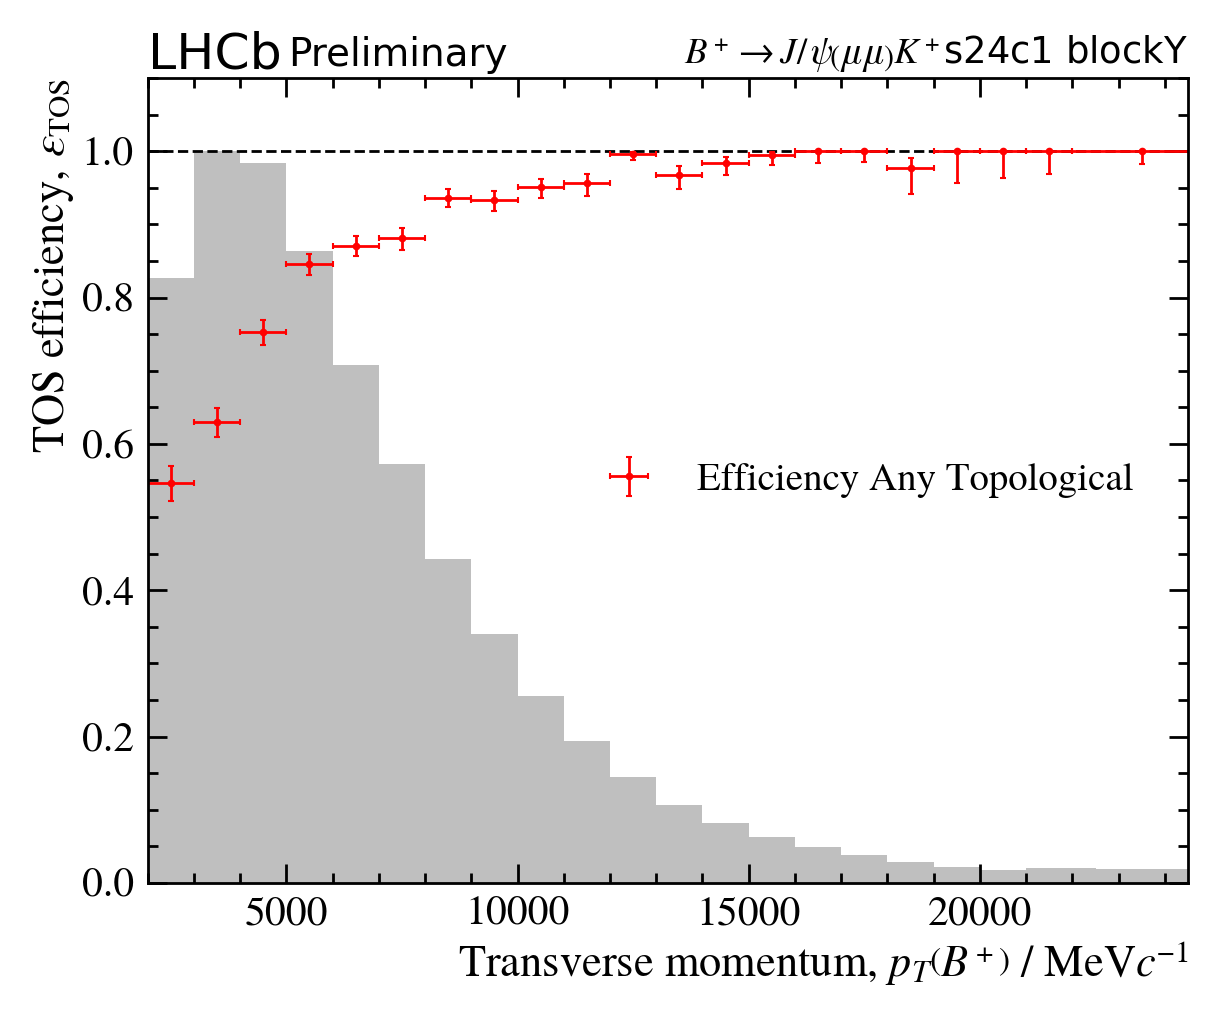

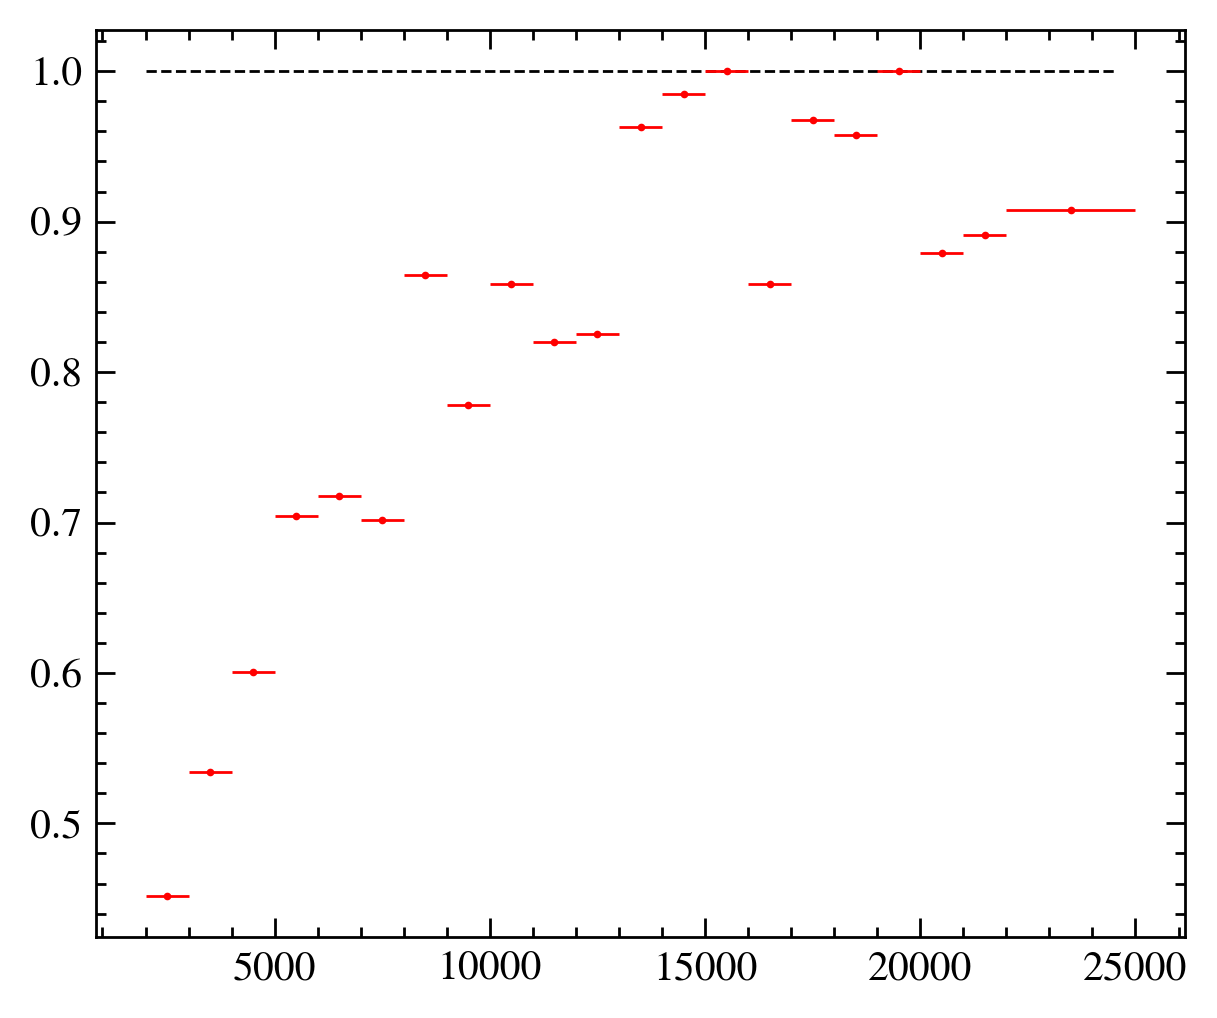

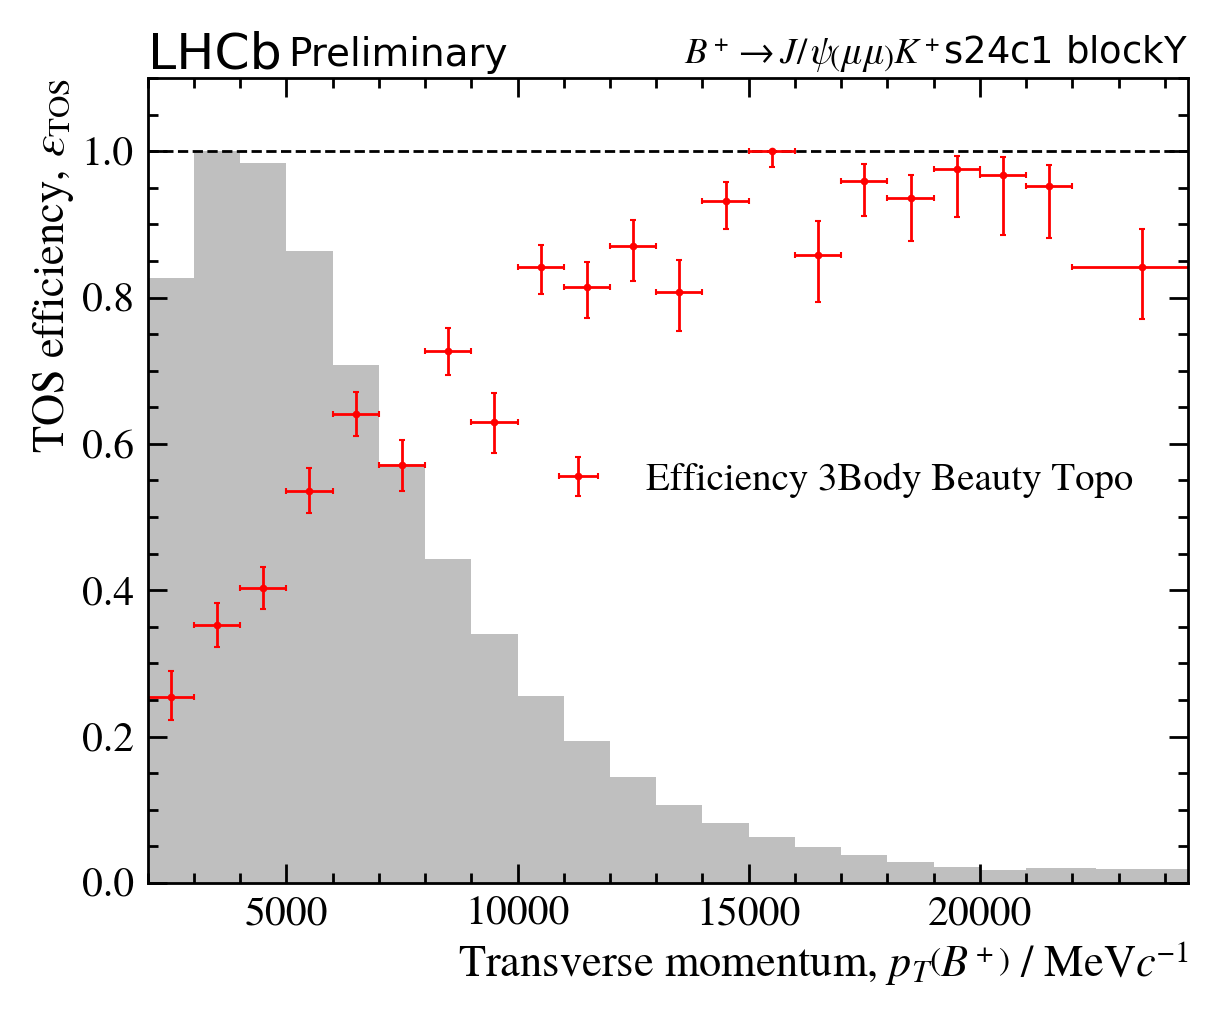

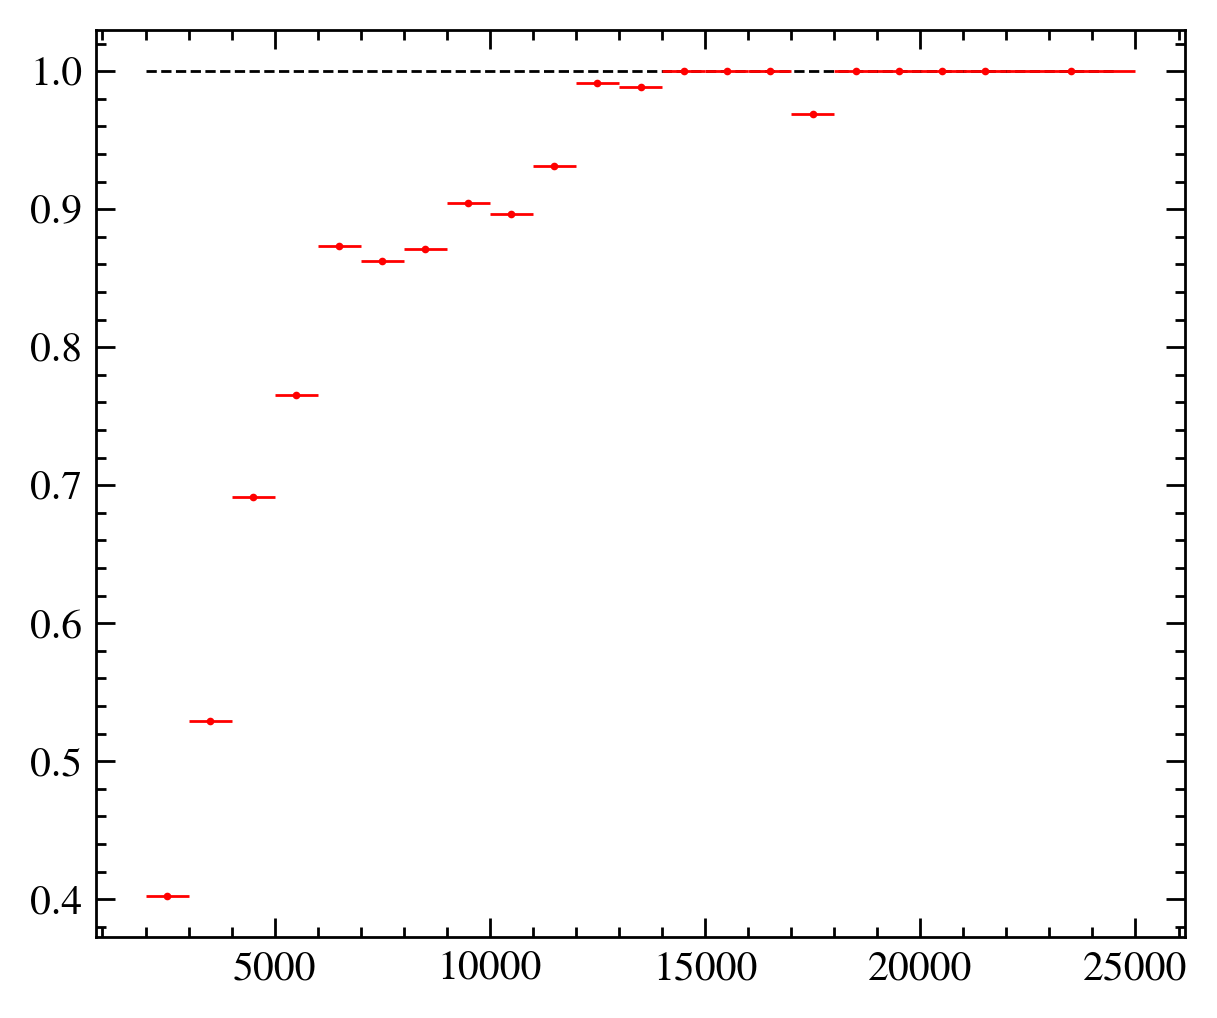

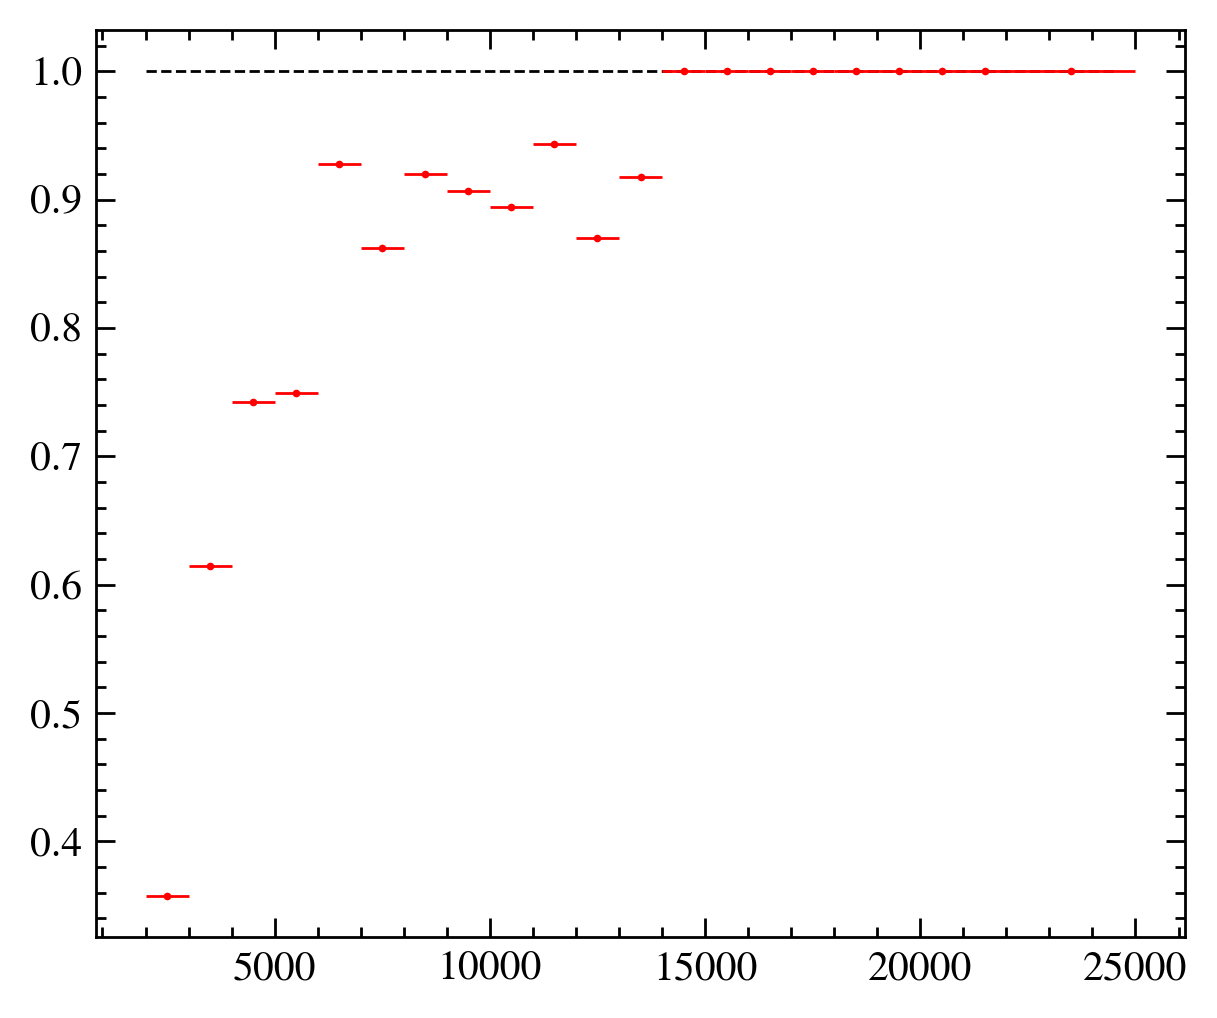

In [12]:
# Define blocks and lines
blocks = [
    (file_c1_blockY, "s24c1 blockY"),
    # (file_c1_blockX, "s24c1 blockX"),
    # (file_c2_block1, "s24c2 block1"),
    # (file_c2_block2, "s24c2 block2"),
    # (file_c2_block3, "s24c2 block3"),
    # (file_c2_block4, "s24c2 block4"),
    # (file_c3_block5, "s24c3 block5"),
    # (file_c3_block6, "s24c3 block6"),
    # (file_c4_block7, "s24c4 block7"),
    # (file_c4_block8, "s24c4 block8")
]

# Define configurations
configurations = [
    (["Hlt2TopoMu3Body", "Hlt2TopoMu2Body", "Hlt2Topo3Body", "Hlt2Topo2Body"], "Any Topological"),
    (["Hlt2TopoMu3Body"], "3Body MuonTopo"),
    (["Hlt2Topo3Body"], "3Body Beauty Topo"),
    (["Hlt2Topo2Body"], "2body Beauty Topo"),
    (["Hlt2TopoMu2Body"], "2body Muon Topo"),
]

# Loop over configurations
for lines, line_label in configurations:
    for file_var, efficiency_name in blocks:
        try:
            dataframe,hlt_eff_object = get_df_and_hlt_eff(file_var, lines)
            plot_TOS_efficiency(
                hlt_eff_object=hlt_eff_object,
                dataframe=dataframe,
                variable="BP_DTFPV_PT",
                efficiency_name=efficiency_name,
                outputpath="plots/BP_DTFPV_PT/single/",
                line=line_label
            )
        except Exception as e:
            print(f"Failed to process {efficiency_name} with lines {lines} and label {line_label}: {e}")


In [31]:
def plot_TOS_efficiency_compare(hlt_eff_object_1,hlt_eff_object_2, dataframe, variable, efficiency_name_1, efficiency_name_2, outputpath, line):
    # Extract efficiency data
    midpoints_1, values_1, xerrors_1, yerrors_1 = tgraph_to_np(hlt_eff_object_1["efficiencies"][f"tos_efficiency_{variable}"])
    midpoints_2, values_2, xerrors_2, yerrors_2 = tgraph_to_np(hlt_eff_object_2["efficiencies"][f"tos_efficiency_{variable}"])

    # Compute bin edges from midpoints
    bin_edges = [midpoints_1[0] - (midpoints_1[1] - midpoints_1[0]) / 2]  # Left edge of the first bin
    for i in range(len(midpoints_1) - 1):
        bin_edges.append(midpoints_1[i] + (midpoints_1[i + 1] - midpoints_1[i]) / 2)
    bin_edges.append(midpoints_1[-1] + (midpoints_1[-1] - midpoints_1[-2]) / 2)  # Right edge of the last bin
    
    # Calculate x-axis range
    xmin, xmax = bin_edges[0], bin_edges[-1]

    # Plot the efficiency
    plt.figure(figsize=(12, 10))
    plt.plot((xmin, xmax), (1, 1), color='k', ls='dashed', lw=2)
    plt.errorbar(
        x=midpoints_1, y=values_1, xerr=[xerrors_1[0], xerrors_1[1]], yerr=yerrors_1,
        color='magenta', elinewidth=2, ls="none", marker='.', markersize=8, label=f"Efficiency {efficiency_name_1}"
    )

    plt.errorbar(
        x=midpoints_2, y=values_2, xerr=[xerrors_2[0], xerrors_2[1]], yerr=yerrors_2,
        color='black', elinewidth=2, ls="none", marker='.', markersize=8, label=f"Efficiency {efficiency_name_2}"
    )
    # Plot variable distribution
    hist_values, _ = np.histogram(dataframe[variable], bins=bin_edges)
    
    # Normalize histogram to match efficiency range
    hist_max = hist_values.max()
    efficiency_max = values_1.max()
    scaling_factor = efficiency_max / hist_max
    scaled_hist_values = hist_values * scaling_factor  # Scale histogram to efficiency range
    
    # Plot histogram as a filled distribution
    plt.bar(
        bin_edges[:-1], scaled_hist_values, width=np.diff(bin_edges), align='edge',
        color='grey', alpha=0.5, edgecolor='none'
    )

    # Set axis limits and labels
    plt.xlim(xmin, xmax)
    plt.ylim(0, max(efficiency_max, scaled_hist_values.max()) * 1.1)  # Adjust y-axis range
    plt.xlabel(r"Transverse momentum, $p_T\left(B^+\right)$ / $\mathrm{MeV}c^{-1}$")
    plt.ylabel(r"TOS efficiency, $\varepsilon_\mathrm{TOS}$")

    # Add labels and legend
    hep.lhcb.label(loc=0, rlabel=r"$B^+\to J/\psi\left(\mu\mu\right)K^+$"+f"{line}", data=True, label="Preliminary", fontsize=20)
    plt.legend()

    os.makedirs(outputpath, exist_ok=True)
        
    # Sanitize filenames
    efficiency_name_1_sanitized = efficiency_name_1.replace(" ", "_")
    efficiency_name_2_sanitized = efficiency_name_2.replace(" ", "_")

    line_sanitized = line.replace(" ", "_")
    
    # Create the filename
    filename = f"TOS_efficiency_{efficiency_name_1}_{efficiency_name_2}_{line_sanitized}.pdf"
    filepath = os.path.join(outputpath, filename)
    
    # Save the plot
    plt.savefig(filepath)
    print(f"Plot saved to {filepath}")




INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockX.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschul

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.73405699, 0.7753304 , 0.94236603, 0.85583104, 0.89098117,
       0.86339444, 0.93049645, 1.        , 0.98944034, 0.92389853,
       0.85844749, 0.8989547 , 0.94688222, 0.88034188, 0.97580645,
       0.99103139, 0.94488189, 0.84210526, 0.85185185, 1.        ,
       0.96534653]))
Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.50182785, 0.61681023, 0.72453271, 0.82932417, 0.84413619,
       0.87393041, 0.89849057, 0.94510135, 0.94237634, 0.95620438,
       0.96926537, 0.98285199, 1.        , 0.96642336, 1.        ,
       0.98484848, 0.9941691 , 1.        , 1.        , 0.97416974,
       1.    

Plot saved to plots/BP_DTFPV_PT/compared/TOS_efficiency_without UT_with UT_Any_Topological.pdf


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockX.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschul

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.53721973, 0.6701603 , 0.84717819, 0.79034091, 0.87168142,
       0.79416168, 0.91872792, 0.99586207, 0.99074074, 0.84044234,
       0.76923077, 0.85581395, 0.95166163, 0.83412322, 0.98283262,
       1.        , 0.890625  , 0.7804878 , 0.55555556, 1.        ,
       1.        ]))
Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.40159929, 0.50718762, 0.66666667, 0.77598511, 0.8240612 ,
       0.82659867, 0.85152613, 0.90781338, 0.92740353, 0.92648287,
       0.94439118, 0.97250859, 1.        , 0.98308271, 1.        ,
       0.98      , 0.99315068, 1.        , 1.        , 1.        ,
       1.    

Plot saved to plots/BP_DTFPV_PT/compared/TOS_efficiency_without UT_with UT_Any_Beauty_Topological.pdf


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockX.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin conta

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.75060827, 0.74405328, 0.91382979, 0.83302583, 0.92242295,
       0.82822086, 0.90186916, 0.97281553, 1.        , 0.97027027,
       0.81775701, 0.94425087, 0.94857143, 0.90540541, 1.        ,
       0.98484848, 1.        , 0.75862069, 1.        , 1.        ,
       0.94214876]))
Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.47973422, 0.63460609, 0.73927393, 0.86441441, 0.83870968,
       0.88029273, 0.90762771, 0.96038151, 0.94810379, 0.9764268 ,
       0.97150611, 0.96357013, 0.98300971, 0.94246575, 1.        ,
       1.        , 0.96446701, 1.        , 1.        , 0.95205479,
       1.    

Plot saved to plots/BP_DTFPV_PT/compared/TOS_efficiency_without UT_with UT_Any_Muon_Topological.pdf


INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockX.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschul

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([ 0.4       ,  0.3611898 ,  0.57973174,  0.66204288,  0.71447721,
        0.66344605,  0.70954357,  0.91007194,  0.93732194,  0.70934256,
        0.84455959,  0.74045802,  0.89156627,  0.65420561,  0.85483871,
        0.95138889,  0.875     , -0.16666667,  0.        ,  1.        ,
        0.91139241]))
Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.16181954, 0.28327402, 0.34945398, 0.47777778, 0.52171429,
       0.56267218, 0.61322314, 0.68011257, 0.73469388, 0.83968463,
       0.88467375, 0.92943548, 0.92887029, 0.96165192, 0.99277978,
       0.91549296, 0.92951542, 0.98198198, 0.89147287, 1.  

INFO:triggercalib.hlteff.hlteff:Initialising HltEff object bu2jpsik
INFO:triggercalib.hlteff.hlteff:Creating RDF from tree 'JPsiK/DecayTree' in path(s) '('/ceph/users/nschulte/TopoCommissioning/s24c1_blockX.root',)'
INFO:triggercalib.hlteff.hlteff:Binning scheme set for variables 'BP_DTFPV_PT'
INFO:triggercalib.hlteff.hlteff:Count mode 'sideband' chosen
INFO:triggercalib.hlteff.hlteff:Calculating TIS, TOS and Trig efficiencies
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin contains more passing events than total events (efficiency > 1), setting N(passing) to N(total)
INFO:triggercalib.hlteff.hlteff:Bin conta

Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.51941238, 0.67609618, 0.82939068, 0.76595745, 0.84604619,
       0.8206661 , 0.907173  , 0.94949495, 0.97249191, 0.83475298,
       0.77060932, 0.84      , 0.94029851, 0.92307692, 0.953125  ,
       1.        , 0.85714286, 0.66666667, 1.        , 1.        ,
       1.        ]))
Values from histogram: (array([ 2500.,  3500.,  4500.,  5500.,  6500.,  7500.,  8500.,  9500.,
       10500., 11500., 12500., 13500., 14500., 15500., 16500., 17500.,
       18500., 19500., 20500., 21500., 23500.]), array([0.4180791 , 0.48      , 0.62607674, 0.75413223, 0.82051282,
       0.8245893 , 0.84424379, 0.88843648, 0.90766208, 0.92679901,
       0.94094488, 0.94276094, 1.        , 0.97450425, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.    

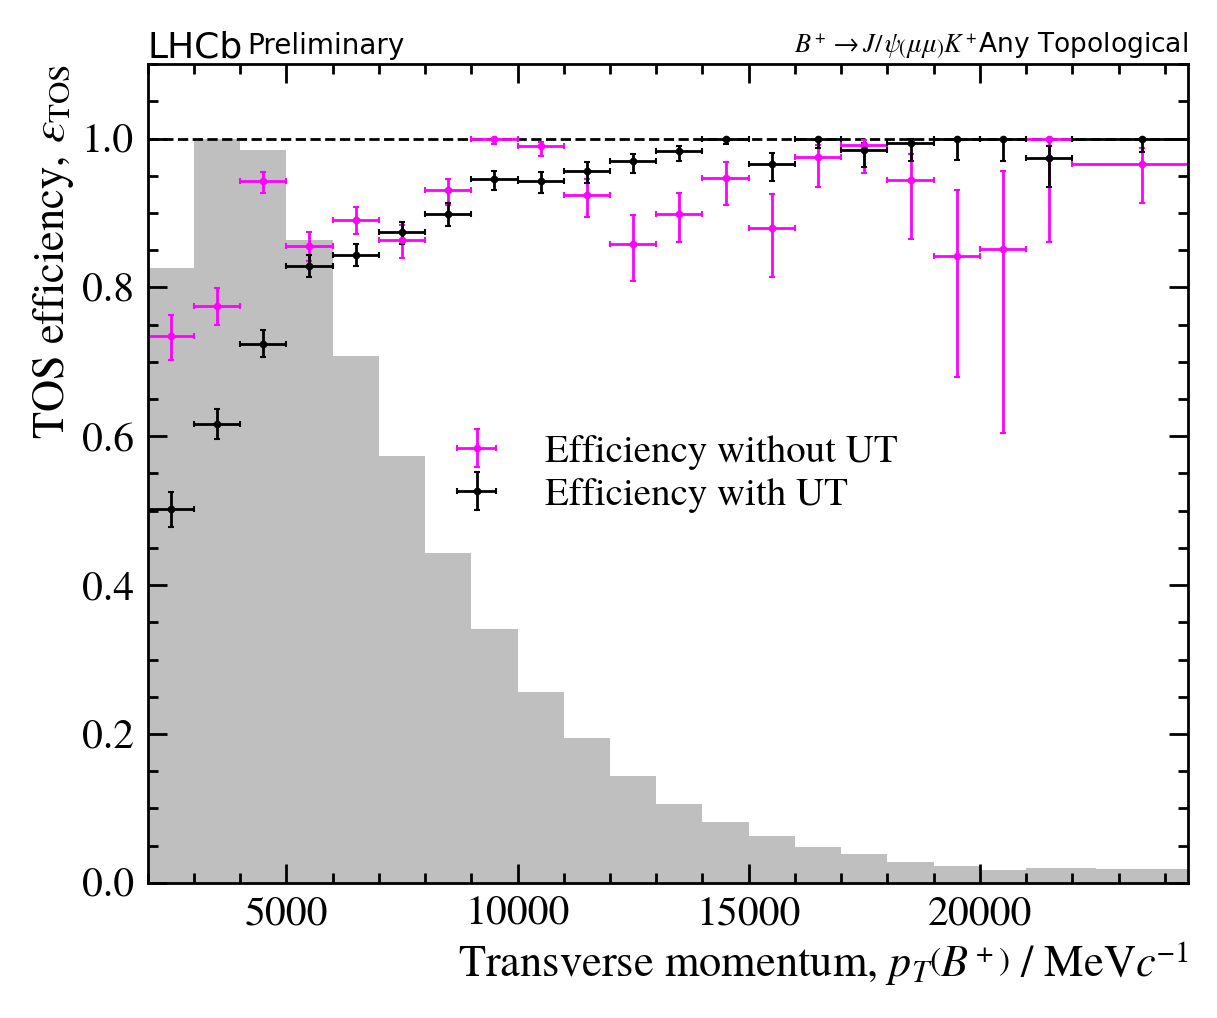

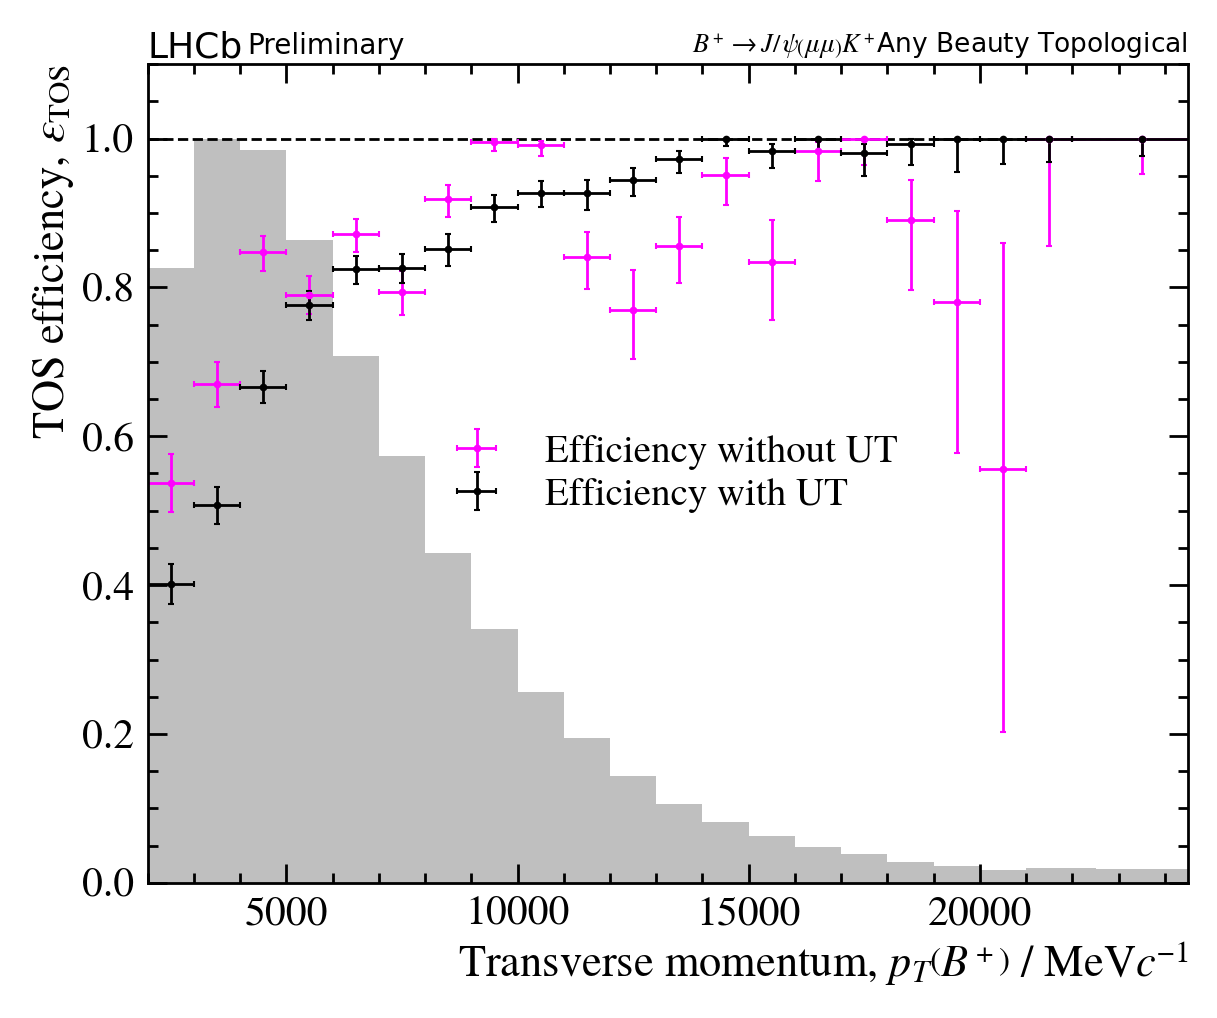

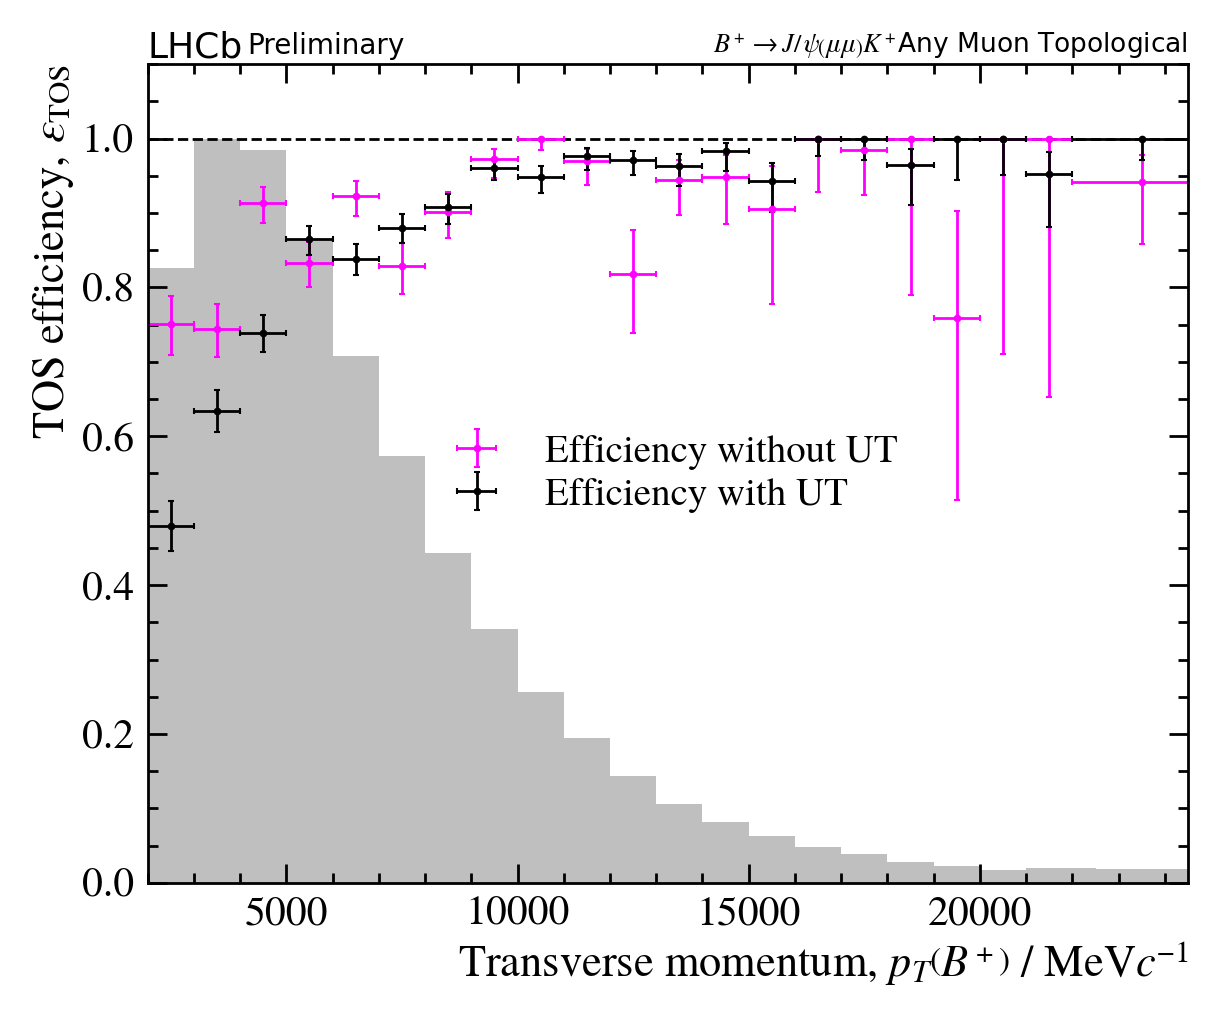

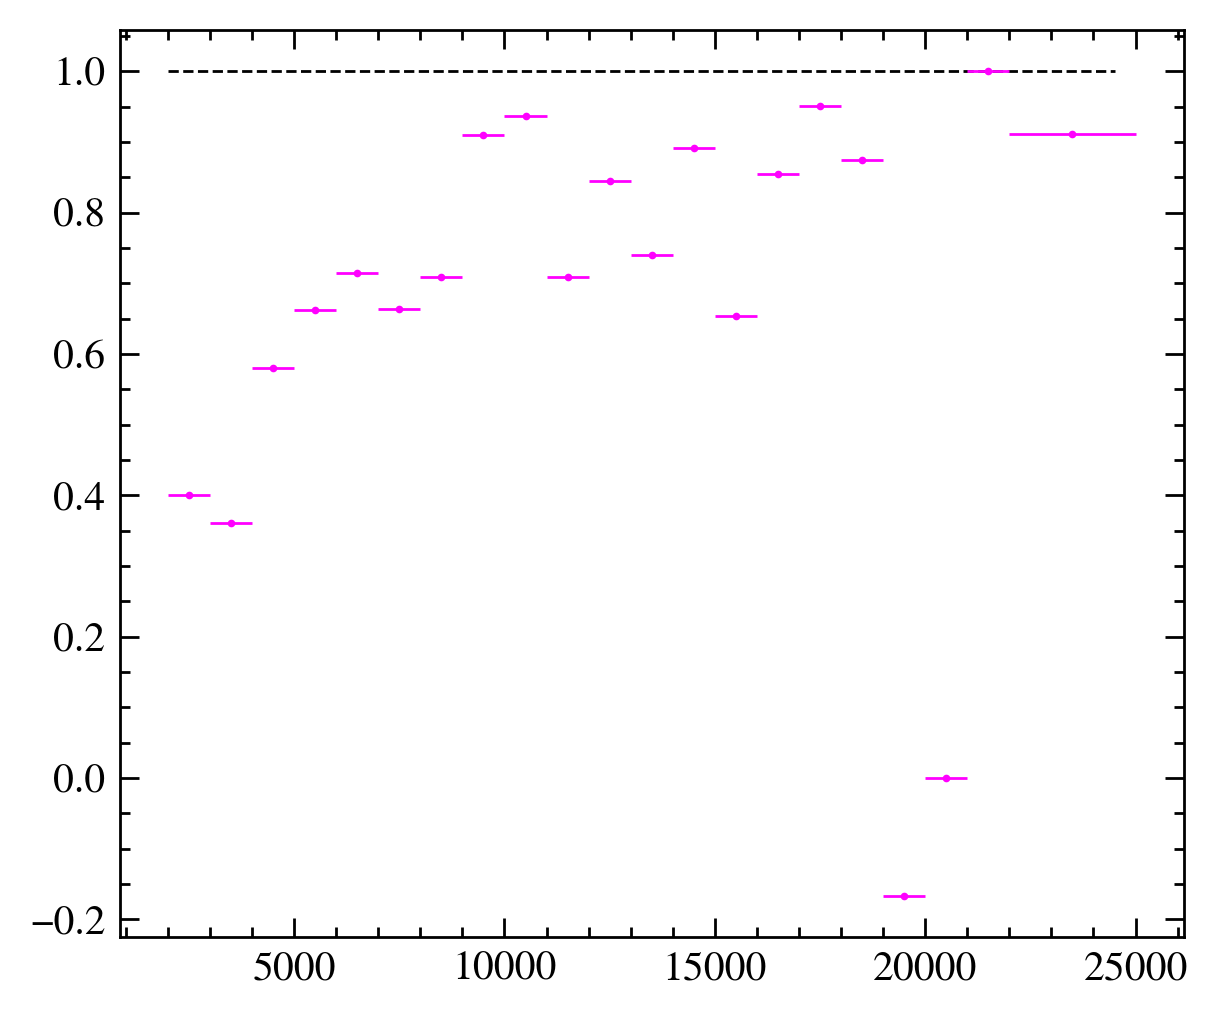

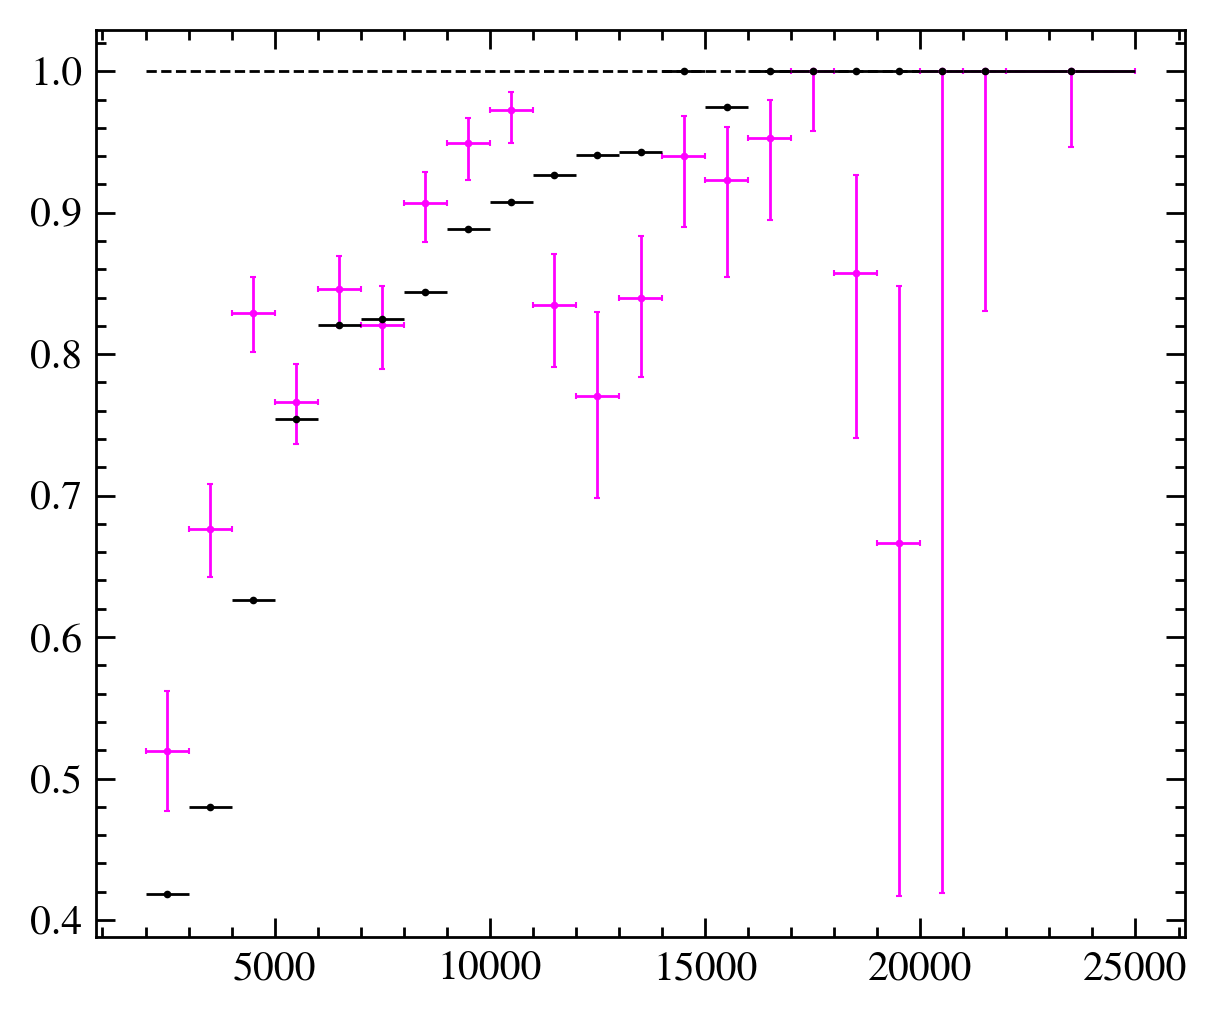

In [33]:
lines = ["Hlt2TopoMu3Body", "Hlt2TopoMu2Body", "Hlt2Topo3Body", "Hlt2Topo2Body"]

try:
    plot_TOS_efficiency_compare(hlt_eff_object_1=get_df_and_hlt_eff(file_c1_blockX,lines)[1], hlt_eff_object_2=get_df_and_hlt_eff(file_c4_block8,lines)[1], dataframe=get_df_and_hlt_eff(file_c1_blockY,lines)[0], variable="BP_DTFPV_PT", efficiency_name_1="without UT", efficiency_name_2="with UT", outputpath="plots/BP_DTFPV_PT/compared/", line="Any Topological")
except Exception as e:
            print(f"Failed to process {efficiency_name} with lines {lines} and label {line_label}: {e}")

lines = ["Hlt2Topo3Body", "Hlt2Topo2Body"]
try:
    plot_TOS_efficiency_compare(hlt_eff_object_1=get_df_and_hlt_eff(file_c1_blockX,lines)[1], hlt_eff_object_2=get_df_and_hlt_eff(file_c4_block8,lines)[1], dataframe=get_df_and_hlt_eff(file_c1_blockY,lines)[0], variable="BP_DTFPV_PT", efficiency_name_1="without UT", efficiency_name_2="with UT", outputpath="plots/BP_DTFPV_PT/compared/", line="Any Beauty Topological")
except Exception as e:
            print(f"Failed to process {efficiency_name} with lines {lines} and label {line_label}: {e}")
lines = ["Hlt2TopoMu3Body", "Hlt2TopoMu2Body"]

try:
    plot_TOS_efficiency_compare(hlt_eff_object_1=get_df_and_hlt_eff(file_c1_blockX,lines)[1], hlt_eff_object_2=get_df_and_hlt_eff(file_c4_block8,lines)[1], dataframe=get_df_and_hlt_eff(file_c1_blockY,lines)[0], variable="BP_DTFPV_PT", efficiency_name_1="without UT", efficiency_name_2="with UT", outputpath="plots/BP_DTFPV_PT/compared/", line="Any Muon Topological")
except Exception as e:
            print(f"Failed to process {efficiency_name} with lines {lines} and label {line_label}: {e}")
lines = ["Hlt2Topo3Body"]

try:
    plot_TOS_efficiency_compare(hlt_eff_object_1=get_df_and_hlt_eff(file_c1_blockX,lines)[1], hlt_eff_object_2=get_df_and_hlt_eff(file_c4_block8,lines)[1], dataframe=get_df_and_hlt_eff(file_c1_blockY,lines)[0], variable="BP_DTFPV_PT", efficiency_name_1="without UT", efficiency_name_2="with UT", outputpath="plots/BP_DTFPV_PT/compared/", line="3Body Beauty Topological")
except Exception as e:
            print(f"Failed to process {efficiency_name} with lines {lines} and label {line_label}: {e}")
lines = ["Hlt2Topo2Body"]

try:
    plot_TOS_efficiency_compare(hlt_eff_object_1=get_df_and_hlt_eff(file_c1_blockX,lines)[1], hlt_eff_object_2=get_df_and_hlt_eff(file_c4_block8,lines)[1], dataframe=get_df_and_hlt_eff(file_c1_blockY,lines)[0], variable="BP_DTFPV_PT", efficiency_name_1="without UT", efficiency_name_2="with UT", outputpath="plots/BP_DTFPV_PT/compared/", line="2Body Beauty Topological")
except Exception as e:
            print(f"Failed to process {efficiency_name} with lines {lines} and label {line_label}: {e}")
